In [162]:
##################################
# IMPORTING BASE AND API LIBRARIES
##################################
from collections import Counter
import pandas as pd
from pandas import read_csv
import pandas_datareader as pdr
import datetime
# from pandas.tools.plotting import scatter_matrix
import numpy as np
from numpy import set_printoptions
import seaborn as sns
from matplotlib import pyplot
from pathlib import Path

# Import the main functionality from the SimFin Python API.
import simfin as sf
# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [163]:
##############################
# IMPORTING MODELING LIBRARIES
##############################
from sklearn import utils
from sklearn import preprocessing
from scipy.stats import uniform

# Pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier

# Resample, model eval, & metrics and enhancements 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_recall_curve

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Ensemble for further improvements
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Performance tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Finalize model with Pickle and joblib
from pickle import dump
from pickle import load
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load

# Getting SimFin data

In [164]:
sf.__version__

'0.3.0'

In [165]:
data_path = r'C:\Users\Roland.Ferrao\Desktop\Data'
sf.set_data_dir(data_path)

In [166]:
sf.load_api_key(default_key='free')

In [167]:
sns.set_style("whitegrid")

In [168]:
%%time
# Data for USA.
market = 'us'

# TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)

# TTM Balance Sheets.
df_balance_ttm = sf.load_balance(variant='ttm', market=market)

# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)

# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market)

# Latest Share-Prices.
# Use refresh_days=0 to always download the latest share-prices.
df_prices = sf.load_shareprices(variant='daily', market=market)
df_prices_latest = sf.load_shareprices(variant='latest', market=market,
                                       refresh_days=30)

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-latest" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Wall time: 1min 20s


In [169]:
tickers = ['MSFT','AAPL','V','MA','INTC','CSCO','ADBE','CRM','NVDA','ACN','AVGO','PYPL','ORCL','IBM','TXN','QCOM','FIS','ADP','INTU','FISV','GPN','AMAT','MU','NOW','ADI','AMD','ADSK','LRCX','CTSH','APH','TEL','HPQ','PAYX','MSI','FLT','KLAC','MCHP','XLNX','GLW','ANSS','HPE','SNPS','VRSN','CDW','KEYS','CDNS','SWKS','MXIM','FTNT','NLOK','NTAP','WDC','IT','AKAM','BR','CTXS','STX','QRVO','LDOS','JKHY','WU','ANET','DXC','JNPR','FFIV','FLIR','XRX','IPGP','ADS']

df_income_qrt = df_income_qrt.loc[tickers].copy()
df_income_ttm = df_income_ttm.loc[tickers].copy()
df_balance_ttm = df_balance_ttm.loc[tickers].copy()
df_cashflow_ttm = df_cashflow_ttm.loc[tickers].copy()
df_cashflow_qrt = df_cashflow_qrt.loc[tickers].copy()
# df_prices_latest = df_prices_latest.loc[tickers].copy()

In [170]:
# df_prices_latest.tail()

In [171]:
# Getting signals for last day of every year
df_price_list = []
df_fin_signals_list = []
df_growth_signals_list = []
df_val_signals_list = []

# setting the price and signals data frames (not including latest year)
shareprice_last_dates = ["2011-12-30", "2012-12-31", "2013-12-31", "2014-12-31", "2015-12-31","2016-12-30", "2017-12-29", "2018-12-31"]

for i in range(len(shareprice_last_dates)):
    df_price_list.append(df_prices.loc[(df_prices.index.get_level_values('Date') == shareprice_last_dates[i])])
    df_fin_signals_list.append(sf.fin_signals(df_prices=df_price_list[i],
                                              df_income_ttm=df_income_ttm,
                                              df_balance_ttm=df_balance_ttm,
                                              fill_method='ffill'))
    df_growth_signals_list.append(sf.growth_signals(df_prices=df_price_list[i],
                                                    df_income_ttm=df_income_ttm,
                                                    df_income_qrt=df_income_qrt,
                                                    df_cashflow_ttm=df_cashflow_ttm,
                                                    df_cashflow_qrt=df_cashflow_qrt,
                                                    fill_method='ffill'))
    df_val_signals_list.append(sf.val_signals(df_prices=df_price_list[i],
                                              df_income_ttm=df_income_ttm,
                                              df_balance_ttm=df_balance_ttm,
                                              df_cashflow_ttm=df_cashflow_ttm,
                                              fill_method='ffill'))

In [172]:
# Latest year signals
df_fin_signals = \
    sf.fin_signals(df_prices=df_prices_latest,
                   df_income_ttm=df_income_ttm,
                   df_balance_ttm=df_balance_ttm,
                   fill_method='ffill')

df_growth_signals = \
    sf.growth_signals(df_prices=df_prices_latest,
                      df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt,
                      fill_method='ffill')

df_val_signals = \
    sf.val_signals(df_prices=df_prices_latest,
                   df_income_ttm=df_income_ttm,
                   df_balance_ttm=df_balance_ttm,
                   df_cashflow_ttm=df_cashflow_ttm,
                   fill_method='ffill')

In [173]:
# Combine the DataFrames (for latest)
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)
df_signals = df_signals.loc[tickers].copy()
# Show the result.
print("Signals")
df_signals.shape

Signals


(66, 25)

In [174]:
df_signals.tail()

,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
VRSN,2019-11-21,1.389877,0.932381,0.841861,0.479427,0.198045,-0.462193,0.273902,0.323322,0.771687,0.008291,...,NaN,0.025106,0.028390,2.320133e+10,-16.746130,39.831358,35.224082,-11.700445,-11.490243,19.096231
WDC,2019-11-21,2.220854,0.399014,0.226447,-0.045507,-0.025791,-0.065389,-2.117037,-0.660929,-1.260582,-0.767373,...,0.041806,-0.053976,0.056553,1.396928e+10,1.401553,-18.526897,17.682633,-1.762463,-1.342748,0.843097
WU,2019-11-21,0.170419,NaN,0.409506,0.152400,0.092283,-1.733618,-2.529169,0.016779,-1.189223,-0.136746,...,0.027820,0.069359,0.039267,1.228243e+10,-39.646327,14.417692,25.466374,-1.473915,-1.473915,2.197254
XLNX,2019-11-21,6.440925,0.321450,0.668651,0.287627,0.185031,0.389569,0.622200,-0.059911,0.052297,0.194007,...,0.015921,0.040990,0.043573,2.323637e+10,8.619135,24.396368,22.949954,24.878154,38.023640,7.017049
XRX,2019-11-21,1.444171,0.351620,0.412920,0.036724,0.022639,0.065553,0.851282,0.539326,-1.825301,-35.656250,...,0.029315,0.019644,-0.003224,9.926693e+09,1.802559,50.906119,-310.209166,-1.905681,-1.294097,0.967043


In [175]:
# Combine the DataFrames (for the previous years.)
dfs_list = [[df_fin_signals_list[i], df_growth_signals_list[i], df_val_signals_list[i]] for i in range(len(df_fin_signals_list))]
df_signals_list = [pd.concat(e, axis=1) for e in dfs_list]
df_signals_list = [e.loc[tickers].copy() for e in df_signals_list]

In [176]:
# Show an example.
print("2018 Signals")
df_signals_list[7].head()

2018 Signals


,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
AAPL,2018-12-31,1.300555,0.306995,0.382085,0.227172,0.146096,0.423905,0.176269,0.413451,-0.004984,0.159609,...,0.018022,0.076829,0.080115,7.735531e+11,6.561540,13.015986,12.482098,-6.726607,-5.044420,2.956871
ACN,2018-12-31,1.330578,0.000922,0.300990,0.099894,0.183292,0.425632,0.181418,0.238164,0.134436,0.265707,...,0.019383,0.045650,0.059567,9.224397e+10,7.065489,21.905650,16.787882,-835.270835,-16.641346,2.188236
ADBE,2018-12-31,1.129248,0.165626,0.867664,0.286907,0.178237,0.306243,0.529424,0.017934,0.352291,0.377703,...,NaN,0.023002,0.033451,1.126320e+11,12.030616,43.474267,29.894513,-24.756849,-21.697877,12.473079
ADI,2018-12-31,1.502076,0.309670,0.682687,0.241162,0.070735,0.147166,1.056258,0.044638,0.245405,1.407814,...,0.021855,0.046470,0.067975,3.218093e+10,2.928590,21.519486,14.711382,-4.378886,-4.088294,5.189684
ADP,2018-12-31,1.045737,0.082675,0.422163,0.130347,0.040505,0.458969,0.040602,0.104472,0.194011,0.597720,...,0.020114,0.031232,0.040513,5.777147e+10,12.126928,32.018773,24.683389,-24.481512,-1.973189,4.173546


In [177]:
df_signals_list[7].shape

(66, 25)

Output of the previous section are `df_signals` (Signals for latest year) `df_signals_list` (Signals for previous years)



# Getting Data from Yahoo Finance

In [178]:
start_sp = datetime.datetime(2011, 1, 1)
end_sp = datetime.datetime(2019, 12, 31)

In [179]:
ticker_symbols_list = ['XLK','MSFT','AAPL','V','MA','INTC','CSCO','ADBE','CRM','NVDA','ACN','AVGO','PYPL','ORCL','IBM','TXN','QCOM','FIS','ADP','INTU','FISV','GPN','AMAT','MU','NOW','ADI','AMD','ADSK','LRCX','CTSH','APH','TEL','HPQ','PAYX','MSI','FLT','KLAC','MCHP','XLNX','GLW','ANSS','HPE','SNPS','VRSN','CDW','KEYS','CDNS','SWKS','MXIM','FTNT','NLOK','NTAP','WDC','IT','AKAM','BR','CTXS','STX','QRVO','LDOS','JKHY','WU','ANET','DXC','JNPR','FFIV','FLIR','XRX','IPGP','ADS']
# create a yearly dataframe with all features, returns (2), nlp, 3 years (2017-2018 on 2019)

In [180]:
close_price_df = pdr.get_data_yahoo(ticker_symbols_list, start_sp, end_sp)['Close']

In [181]:
close_price_df.shape

(2253, 70)

In [182]:
# Yearly returns
multpl_stock_yearly_returns = close_price_df.resample('Y').ffill().pct_change()
multpl_stock_yearly_returns.head()

Symbols,AAPL,ACN,ADBE,ADI,ADP,ADS,ADSK,AKAM,AMAT,AMD,...,SWKS,TEL,TXN,V,VRSN,WDC,WU,XLK,XLNX,XRX
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31,0.314000,0.249296,0.332862,0.175517,0.054064,0.394068,0.165513,0.267348,0.068161,-0.555556,...,0.251541,0.204804,0.061147,0.492958,0.086786,0.372859,-0.254655,0.133595,0.118528,-0.143216
2013-12-31,0.054212,0.236391,0.589172,0.210889,0.419287,0.816317,0.423480,0.153263,0.545455,0.612500,...,0.406897,0.484644,0.421496,0.469059,0.539928,0.974582,0.267450,0.238822,0.280535,0.784458
2014-12-31,0.377241,0.086232,0.214095,0.090124,0.175228,0.087932,0.193561,0.334464,0.409502,-0.310077,...,1.545868,0.147705,0.217718,0.177474,-0.046504,0.319428,0.038261,0.156967,-0.057273,0.138866
2015-12-31,-0.046385,0.170082,0.292160,-0.003602,0.016193,-0.033141,0.014485,-0.164072,-0.250803,0.074906,...,0.056663,0.021502,0.025061,0.183066,0.532632,-0.457543,0.000000,0.035792,0.085008,-0.233045


In [183]:
# Melting yearly returns
multpl_stock_yearly_returns = multpl_stock_yearly_returns.reset_index(drop = False)
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns.melt(id_vars=["Date", "XLK"], 
        var_name="TickerSymbol", 
        value_name="YearlyReturn")

In [184]:
multpl_stock_yearly_returns_melt.head()

,Date,XLK,TickerSymbol,YearlyReturn
0,2011-12-31,NaN,AAPL,NaN
1,2012-12-31,0.133595,AAPL,0.314000
2,2013-12-31,0.238822,AAPL,0.054212
3,2014-12-31,0.156967,AAPL,0.377241
4,2015-12-31,0.035792,AAPL,-0.046385


In [185]:
# changing XLK returns column name
multpl_stock_yearly_returns_melt.rename(columns = {'XLK':'XLK_Return'}, inplace = True)

In [186]:
multpl_stock_yearly_returns_melt.head()

,Date,XLK_Return,TickerSymbol,YearlyReturn
0,2011-12-31,NaN,AAPL,NaN
1,2012-12-31,0.133595,AAPL,0.314000
2,2013-12-31,0.238822,AAPL,0.054212
3,2014-12-31,0.156967,AAPL,0.377241
4,2015-12-31,0.035792,AAPL,-0.046385


In [187]:
threshold = 0.05 
delta_value = threshold * multpl_stock_yearly_returns_melt['YearlyReturn']
win = np.where(multpl_stock_yearly_returns_melt['XLK_Return'] - multpl_stock_yearly_returns_melt['YearlyReturn'] >= delta_value, 1, 0)

In [188]:
multpl_stock_yearly_returns_melt['win'] = win

In [189]:
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns_melt.sort_values(by=['Date','TickerSymbol'])
multpl_stock_yearly_returns_melt.head()

,Date,XLK_Return,TickerSymbol,YearlyReturn,win
0,2011-12-31,NaN,AAPL,NaN,0
9,2011-12-31,NaN,ACN,NaN,0
18,2011-12-31,NaN,ADBE,NaN,0
27,2011-12-31,NaN,ADI,NaN,0
36,2011-12-31,NaN,ADP,NaN,0


In [190]:
multpl_stock_yearly_returns_melt = multpl_stock_yearly_returns_melt.reset_index(drop = True)
multpl_stock_yearly_returns_melt.head()

,Date,XLK_Return,TickerSymbol,YearlyReturn,win
0,2011-12-31,NaN,AAPL,NaN,0
1,2011-12-31,NaN,ACN,NaN,0
2,2011-12-31,NaN,ADBE,NaN,0
3,2011-12-31,NaN,ADI,NaN,0
4,2011-12-31,NaN,ADP,NaN,0


In [191]:
for e in df_signals_list:
    print(e.shape)

(59, 25)
(60, 25)
(61, 25)
(63, 25)
(66, 25)
(66, 25)
(66, 25)
(66, 25)


In [192]:
# Replacing NaNs with median of columns
for e in df_signals_list:
    for col in e:
        e[col] = e[col].fillna(e[col].median())

In [193]:
# appending signals dfs
all_years_signals = df_signals_list[0]
for i in range(1, len(df_signals_list)):
    all_years_signals = all_years_signals.append(df_signals_list[i])

In [194]:
all_years_signals.tail()

,,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
Ticker,Date,,,,,,,,,,,,,,,,,,,,,
VRSN,2018-12-31,1.389877,0.932381,0.841861,0.479427,0.198045,-0.462193,0.273902,0.323322,0.771687,0.008291,...,0.020114,0.032024,0.036212,1.818940e+10,-13.128647,31.227027,27.615010,-9.172927,-9.008132,14.971081
WDC,2018-12-31,2.239540,0.379899,0.334537,0.043371,0.028184,0.074610,1.178756,-1.953033,-0.408262,-0.401879,...,0.052583,0.074953,0.192863,1.122040e+10,1.028262,13.341730,5.185025,-1.540205,-1.120443,0.578639
WU,2018-12-31,0.170419,0.257605,0.409506,0.152400,0.092283,-1.733618,-2.529169,0.016779,-1.189223,-0.136746,...,0.044079,0.109893,0.062216,7.752064e+09,-25.022802,9.099735,16.073116,-0.930263,-0.930263,1.386798
XLNX,2018-12-31,4.378726,0.321450,0.695999,0.280082,0.159104,0.344472,0.641032,0.109628,19.038510,0.154313,...,0.016716,0.037596,0.044480,2.166616e+10,8.215609,26.598902,22.481802,14.893054,18.625178,7.449869
XRX,2018-12-31,1.444171,0.351620,0.412920,0.036724,0.022639,0.065553,0.851282,0.539326,-1.825301,-35.656250,...,0.057398,0.038463,-0.006312,5.069823e+09,0.920614,25.999093,-158.431975,-0.973281,-0.660929,0.493894


In [195]:
all_years_signals = all_years_signals.reset_index(drop = True)

In [196]:
all_years_signals.tail()

,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
502,1.389877,0.932381,0.841861,0.479427,0.198045,-0.462193,0.273902,0.323322,0.771687,0.008291,...,0.020114,0.032024,0.036212,1.818940e+10,-13.128647,31.227027,27.615010,-9.172927,-9.008132,14.971081
503,2.239540,0.379899,0.334537,0.043371,0.028184,0.074610,1.178756,-1.953033,-0.408262,-0.401879,...,0.052583,0.074953,0.192863,1.122040e+10,1.028262,13.341730,5.185025,-1.540205,-1.120443,0.578639
504,0.170419,0.257605,0.409506,0.152400,0.092283,-1.733618,-2.529169,0.016779,-1.189223,-0.136746,...,0.044079,0.109893,0.062216,7.752064e+09,-25.022802,9.099735,16.073116,-0.930263,-0.930263,1.386798
505,4.378726,0.321450,0.695999,0.280082,0.159104,0.344472,0.641032,0.109628,19.038510,0.154313,...,0.016716,0.037596,0.044480,2.166616e+10,8.215609,26.598902,22.481802,14.893054,18.625178,7.449869
506,1.444171,0.351620,0.412920,0.036724,0.022639,0.065553,0.851282,0.539326,-1.825301,-35.656250,...,0.057398,0.038463,-0.006312,5.069823e+09,0.920614,25.999093,-158.431975,-0.973281,-0.660929,0.493894


In [197]:
print(multpl_stock_yearly_returns_melt.shape)
print(all_years_signals.shape)

(621, 5)
(507, 25)


In [198]:
# Separating latest data
# multpl_stock_yearly_returns_melt['Date'] = pd.to_datetime(multpl_stock_yearly_returns_melt['Date'])
yearly_returns_latest_df = multpl_stock_yearly_returns_melt[multpl_stock_yearly_returns_melt['Date'].dt.year == 2019]
yearly_returns_df = multpl_stock_yearly_returns_melt[multpl_stock_yearly_returns_melt['Date'].dt.year != 2019]

In [199]:
print(yearly_returns_df.shape)
print(yearly_returns_latest_df.shape)

(552, 5)
(69, 5)


In [200]:
yearly_returns_df = yearly_returns_df.drop(columns = ["TickerSymbol", "Date"])
yearly_returns_latest_df = yearly_returns_latest_df.drop(columns = ["TickerSymbol", "Date"])

In [201]:
yearly_returns_df = yearly_returns_df.reset_index(drop = True)
yearly_returns_latest_df = yearly_returns_latest_df.reset_index(drop = True)

In [202]:
print(yearly_returns_df.shape)
print(all_years_signals.shape)

(552, 3)
(507, 25)


In [203]:
final_df = pd.concat([yearly_returns_df, all_years_signals], axis=1)

In [204]:
final_df.head()

,XLK_Return,YearlyReturn,win,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
0,NaN,NaN,0,1.608438,0.149110,0.404789,0.239466,0.344785,0.542403,0.849854,...,0.016187,0.068334,0.079288,3.793409e+11,4.951262,14.633938,12.612326,72.504003,-40.401624,3.504337
1,NaN,NaN,0,1.451160,0.000417,0.305433,0.083792,0.185335,0.720317,0.275050,...,0.020256,0.060548,0.086530,3.939088e+10,9.336138,16.515754,11.556717,-498.985125,-11.316130,1.383893
2,NaN,NaN,0,3.360781,0.178550,0.894718,0.227890,0.116770,0.182498,0.958640,...,0.016187,0.064662,0.081273,1.435112e+10,2.579300,15.464932,12.304213,26.556668,68.349719,3.524304
3,NaN,NaN,0,8.354869,0.167949,0.663658,0.289777,0.200376,0.271085,0.218106,...,0.025536,0.078649,0.070501,1.102868e+10,2.905793,12.714734,14.184201,3.797591,4.378039,3.684432
4,NaN,NaN,0,1.094687,0.149110,0.416986,0.126393,0.041400,0.222072,0.060209,...,0.026109,0.047539,0.056627,2.689159e+10,4.467634,21.035345,17.659302,59.363324,-1.357796,2.658716


In [205]:
final_df.shape

(552, 28)

In [206]:
df_signals = df_signals.reset_index(drop = True)

In [207]:
print(yearly_returns_latest_df.shape)
print(df_signals.shape)

(69, 3)
(66, 25)


In [208]:
df_signals.head()

,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
0,1.540126,0.319178,0.378178,0.212381,0.151086,0.515703,-0.071811,0.362605,-0.031080,-0.081487,...,0.011591,0.045364,0.048352,1.218062e+12,13.461030,22.043972,20.681569,-14.294989,-9.499520,4.681720
1,1.396741,0.000761,0.308103,0.110589,0.195472,0.445622,0.177148,-0.095308,0.098009,0.113310,...,0.014571,0.037352,0.047113,1.279473e+11,8.628944,26.772194,21.225697,261.965953,-25.020021,2.960714
2,0.966122,0.211714,0.860408,0.280772,0.179113,0.310624,0.427639,-0.005896,0.156352,0.304345,...,NaN,0.018077,0.025757,1.483637e+11,15.029521,55.319561,38.824748,-32.967247,-27.469483,15.532200
3,1.001142,0.263837,0.677884,0.247099,0.073887,0.139854,0.076706,-0.015119,-0.125680,-0.063434,...,0.018626,0.037372,0.049213,4.062647e+10,3.445773,26.758188,20.319983,-5.229067,-4.878525,6.611917
4,1.010534,0.053154,0.429114,0.165169,0.063335,0.506497,0.382937,0.224816,0.152355,0.219410,...,0.017989,0.031964,0.032489,7.413964e+10,13.830217,31.285190,30.779941,-26.055050,-2.903202,5.167354


In [209]:
final_test_df= pd.concat([yearly_returns_latest_df, df_signals], axis=1)
final_test_df.shape
# df_signals.head()

(69, 28)

Output of the previous section are `final_df` (for train data) `final_test_df` (for test data), both including `win` column

In [210]:
# final_df.isnull().sum()

In [211]:
# df_signals_list[5].isnull().sum()

# Add additional features

In [212]:
# NLP, FRED

# Data discovery and visualizations

In [213]:
master_df = pd.concat([final_df, final_test_df], axis = 0)
# master_df.shape

In [214]:
master_df.isnull().sum()

XLK_Return             69
YearlyReturn           98
win                     0
Current Ratio          48
Debt Ratio             52
Gross Profit Margin    48
Net Profit Margin      48
Return on Assets       49
Return on Equity       49
Earnings Growth        49
Earnings Growth QOQ    49
Earnings Growth YOY    49
FCF Growth             49
FCF Growth QOQ         49
FCF Growth YOY         49
Sales Growth           49
Sales Growth QOQ       49
Sales Growth YOY       49
Dividend Yield         68
Earnings Yield         48
FCF Yield              48
Market-Cap             48
P/Book                 48
P/E                    48
P/FCF                  48
P/NCAV                 48
P/NetNet               48
P/Sales                48
dtype: int64

In [215]:
# master_df.describe()

In [216]:
# correlations = master_df.corr()

In [217]:
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# pyplot.show()

# Feature Engineering  

In [218]:
# Feature selection - Univariate, recursive feature elimination, PCA and feature importance

In [219]:
# master_df = master_df[~master_df.isin([np.nan, np.inf, -np.inf]).any(1)]
# master_df.shape # 550*25
# X = master_df.iloc[:,1:]
# Y = master_df['win']

In [220]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt

# model = ExtraTreesClassifier()
# model.fit(X,Y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [221]:
# univariate - non-negative input
# test = SelectKBest(score_func=chi2, k=4)
# fit = test.fit(X, Y)
# set_printoptions(precision=3)
# print(fit.scores_)
# features = fit.transform(X)
# # summarize selected features
# print(features[0:5,:])

In [222]:
# PCA
# pca = PCA(n_components=3)
# fit = pca.fit(X)

In [223]:
# feature extraction
# model = LogisticRegression()
# rfe = RFE(model, 3)
# fit = rfe.fit(X, Y)
# print("Num Features: %d") % fit.n_features_
# print("Selected Features: %s") % fit.support_
# print("Feature Ranking: %s") % fit.ranking_

# Create target and features for train and test

In [224]:
print(final_df.shape)
print(final_test_df.shape)

(552, 28)
(69, 28)


In [225]:
names = list(final_df.columns)
names[0], names[2] = names[2], names[0]
final_df = final_df.reindex(names, axis=1)

names = list(final_test_df.columns)
names[0], names[2] = names[2], names[0]
final_test_df = final_test_df.reindex(names, axis=1)

In [226]:
final_test_df.head()

,win,YearlyReturn,XLK_Return,Current Ratio,Debt Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,...,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
0,0,0.744326,0.443853,1.540126,0.319178,0.378178,0.212381,0.151086,0.515703,-0.071811,...,0.011591,0.045364,0.048352,1.218062e+12,13.461030,22.043972,20.681569,-14.294989,-9.499520,4.681720
1,0,0.465570,0.443853,1.396741,0.000761,0.308103,0.110589,0.195472,0.445622,0.177148,...,0.014571,0.037352,0.047113,1.279473e+11,8.628944,26.772194,21.225697,261.965953,-25.020021,2.960714
2,1,0.405322,0.443853,0.966122,0.211714,0.860408,0.280772,0.179113,0.310624,0.427639,...,NaN,0.018077,0.025757,1.483637e+11,15.029521,55.319561,38.824748,-32.967247,-27.469483,15.532200
3,1,0.383782,0.443853,1.001142,0.263837,0.677884,0.247099,0.073887,0.139854,0.076706,...,0.018626,0.037372,0.049213,4.062647e+10,3.445773,26.758188,20.319983,-5.229067,-4.878525,6.611917
4,1,0.283252,0.443853,1.010534,0.053154,0.429114,0.165169,0.063335,0.506497,0.382937,...,0.017989,0.031964,0.032489,7.413964e+10,13.830217,31.285190,30.779941,-26.055050,-2.903202,5.167354


In [227]:
# drop the yearly returns and market-cap
final_df = final_df.drop(columns = ["YearlyReturn", "XLK_Return", "Market-Cap"])
final_test_df = final_test_df.drop(columns = ["YearlyReturn", "XLK_Return", "Market-Cap"])

In [228]:
train_array = final_df.values
test_array = final_test_df.values

In [229]:
Y_train = train_array[0:,0]
Y_test = test_array[0:,0]

In [230]:
X_train = train_array[0:,1:]
X_test = test_array[0:,1:]

In [231]:
# np.savetxt("foo.csv", array, delimiter=",")
print(X_train.shape)
print(X_test.shape)

(552, 24)
(69, 24)


In [232]:
Y_test

array([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       0.])

In [233]:
# mask = ~np.any(np.isnan(X_train), axis=1)
# mask_test = ~np.any(np.isnan(X_test), axis=1)

# X_train = X_train[mask]
# Y_train = Y_train[mask]

# X_test = X_test[mask_test]
# Y_test = Y_test[mask_test]

In [234]:
## The one we use
X_train[np.where(np.isnan(X_train))] = np.take(np.nanmedian(X_train, axis=0), np.where(np.isnan(X_train))[1])
X_test[np.where(np.isnan(X_test))] = np.take(np.nanmedian(X_test, axis=0), np.where(np.isnan(X_test))[1])

In [235]:
# replace posinf with max value
X_train[np.where(np.isposinf(X_train))] = np.NINF
X_train[np.where(np.isneginf(X_train))] = np.take(np.max(X_train, axis=0), np.where(np.isneginf(X_train))[1])

In [236]:
np.any(np.isnan(X_train))

False

In [237]:
np.any(np.isinf(X_train))

False

In [238]:
# X_train= preprocessing.normalize(X_train, norm='l2')
# X_test = preprocessing.normalize(X_test, norm='l2')

In [239]:
print(X_train.shape)
print(X_test.shape)

(552, 24)
(69, 24)


In [240]:
# Creating X and Y 
# X = np.append(X_train, X_test, axis=0)
# Y = np.append(Y_train, Y_test, axis=0)
X = X_train
Y = Y_train

# Model Pre-processing: Scale, standardize, normalize or binarize

In [241]:
# Scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# rescaledX = scaler.fit_transform(X)
# # summarize transformed data
# set_printoptions(precision=3)

In [242]:
# Standardize
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
# summarize transformed data
set_printoptions(precision=3)
print(rescaledX[0:5,:])

[[-5.183e-01 -5.552e-01 -8.240e-01  7.915e-01  3.304e+00  1.818e-01
   1.268e-01 -3.769e-02  1.092e-01  2.865e-01 -5.049e-02  6.399e-02
   4.172e+00 -3.827e-01  2.217e-02 -2.856e-01  4.200e-01  3.638e-01
   3.316e-02 -5.025e-02 -1.518e-01  2.462e-01 -2.361e-01 -2.286e-01]
 [-6.128e-01 -1.616e+00 -1.344e+00 -6.469e-01  1.159e+00  2.522e-01
   4.254e-02  2.172e-02  3.376e-02  7.908e-02 -8.890e-02  3.087e+00
   7.543e-01  6.078e-02 -2.789e-02 -4.176e-02  2.845e-01  5.025e-01
   1.692e-01 -4.648e-02 -1.702e-01 -1.231e+00 -1.178e-02 -9.455e-01]
 [ 5.339e-01 -3.451e-01  1.738e+00  6.846e-01  2.373e-01  3.933e-02
   1.428e-01 -6.092e-02 -4.534e-02  7.218e-02 -2.680e-02 -1.373e-02
   4.055e-01 -3.775e-01 -6.193e-02 -2.856e-01  3.561e-01  4.019e-01
  -4.041e-02 -4.858e-02 -1.572e-01  1.274e-01  6.027e-01 -2.219e-01]
 [ 3.533e+00 -4.207e-01  5.296e-01  1.256e+00  1.362e+00  7.439e-02
   3.419e-02 -6.752e-02 -5.258e-02 -5.918e-02  9.877e-04 -2.731e-02
  -6.005e-02 -6.718e-01 -8.329e-02  2.746e-01

In [243]:
# Normalize
# scaler = Normalizer().fit(X)
# normalizedX = scaler.transform(X)
# # summarize transformed data
# set_printoptions(precision=3)
# print(normalizedX[0:5,:])

In [244]:
# Binarize
# binarizer = Binarizer(threshold=0.0).fit(X)
# binaryX = binarizer.transform(X)
# # summarize transformed data
# set_printoptions(precision=3)
# print(binaryX[0:5,:])

In [245]:
X = rescaledX

# Classification algorithms

In [246]:
# Classification: Logisitc, LDA, k-nearest neighbors, Naive bayes, classification and regression trees, & SVM

In [247]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
best = -np.inf
best_model = None
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    if cv_results.mean() > best:
        best = cv_results.mean()
        best_model = model
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.595552 (0.109636)
LDA: 0.599123 (0.113529)
KNN: 0.564708 (0.106459)
CART: 0.516266 (0.052908)
NB: 0.617143 (0.138432)
SVM: 0.615195 (0.149110)


In [248]:
best

0.6171428571428571

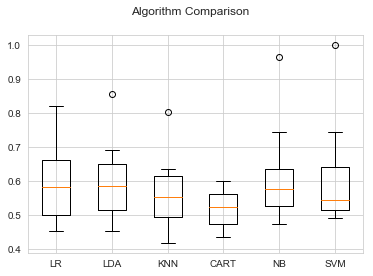

In [249]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Improve performance with Ensemble models

In [250]:
# bagging (bag decision trees, random forest, extra trees), boosting (adaBoost, gradient), voting (combine multiple)

In [251]:
# Bagged decision trees
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
cart = best_model
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.6298376623376624


In [252]:
# Random forest
num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=7)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5824999999999999


In [253]:
# Extra trees
num_trees = 100
max_features = 7
kfold = KFold(n_splits=10, random_state=7)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5773376623376623


In [254]:
# AdaBoost
num_trees = 30
seed=7
kfold = KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5684090909090909


In [255]:
# Stochastic gradient
seed = 7
num_trees = 100
kfold = KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5845454545454546


In [256]:
# Voting
kfold = KFold(n_splits=10, random_state=7)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = GaussianNB()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

0.6115909090909091


# Improve performance with Algorithm tunning

In [257]:
# Using grid search and random search

In [258]:
# param_grid = {
#     'base_estimator__max_depth' : [1, 2, 3, 4, 5],
#     'max_samples' : [0.05, 0.1, 0.2, 0.5]
# }

# clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
#                                      n_estimators = 100, max_features = 0.5),
#                    param_grid, scoring = 'accuracy')
# clf.fit(X_train, Y_train)

In [259]:
# # Grid Search for Algorithm Tuning
# alphas = numpy.array([1,0.1,0.01,0.001,0.0001,0])
# param_grid = dict(alpha=alphas)
# model = Ridge()
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid.fit(X, Y)
# print(grid.best_score_)
# print(grid.best_estimator_.alpha)

# Save, load and score

In [260]:
model = best_model
model.fit(X_train, Y_train)

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

# load the model from disk and score
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.36231884057971014


# Predictions

In [261]:
# Make predictions from the x test dataset
predictions = loaded_model.predict(X_test)

In [262]:
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0.])

In [263]:
len(predictions)

69